So I could choose to use the inbuilt `compile` method. Alternatively I could pursue my own fun and form of quaility.

In [76]:
from h5py import File
from os import getcwd

from numpy import array, diag, transpose, zeros, arange   # Array manipulation 
from numpy import log, sum, exp, sin, pi   # Mathematical operations
from numpy import float32 # Types

from matplotlib.pyplot import plot

In [77]:
UNIT_FACTOR = 14.003242 / 6.022 * 5.11 * 31536. / 1.e5

In [78]:
model = File(f"{getcwd()}/models/Guttler14.hd5")
model = {key: array([*value]) for key, value in model.items()}

In [79]:
decay = diag([log(2) / 5730] * len(model["fluxes"]))
yinitial = model["reservoir content"]
fluxes = model["fluxes"] / transpose(yinitial)
balance = diag(sum(fluxes, axis=1))
transfer = transpose(fluxes) - balance - decay
projection = model["production coefficients"]

In [80]:
def production(t, *args, steady_state=1.86):
    start, duration, phase, area = args

    middle = start + duration / 2.
    height = area / duration
    gaussian = height * exp(- ((t - middle) / (duration / 2)) ** 16.)
    sinusoid = 0.18 * steady_state * sin(2 * pi / 11 * t + phase)
    production = gaussian + sinusoid + steady_state
    
    return UNIT_FACTOR * production

In [81]:
def dydx(y, t, *args):
    return transfer @ y + production(t, *args) * projection

In [82]:
def odeint_linear(y0, derivative, timesteps, parameters=()):
    step_size = timesteps[1] - timesteps[0]
    output = zeros((y0.shape[1], timesteps.shape[0]))
    output[:, 0] = y0
    for j, step in enumerate(timesteps[:-1]):
        output[:, j+1] = output[:, j] + step_size * \
            derivative(output[:, j], step, *parameters)
    return output 

In [83]:
time_out = arange(-225, 775, 0.1)

In [ ]:
test = odeint_linear(yinitial, dydx, time_out, parameters=(774.86, 0.25, 0.8, 6.44))

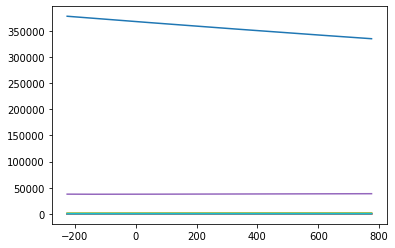

In [86]:
plot(time_out, transpose(test))